# Load dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

In [3]:
#### from https://github.com/gngdb/pytorch-pca/tree/main ####
def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = torch.argmax(torch.abs(u), 0)
    i = torch.arange(u.shape[1]).to(u.device)
    signs = torch.sign(u[max_abs_cols, i])
    u *= signs
    v *= signs.view(-1, 1)
    return u, v

class TorchPCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    #@torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

In [4]:
def rank_tensor(x):
    """
    Returns the ranks of the elements in the input tensor x.
    """
    tmp = x.argsort()
    ranks = torch.zeros_like(tmp)
    ranks[tmp] = torch.arange(len(x), device=x.device)
    return ranks

def spearman_corr(x, y):
    """
    Calculates the differentiable Spearman correlation between two tensors x and y.
    """
    assert x.shape == y.shape, "Input tensors must have the same shape"
    
    n = x.size(0)

    # Rank the tensors
    x_rank = rank_tensor(x).float()
    y_rank = rank_tensor(y).float()
    
    # Compute the covariance between the ranks
    x_rank_mean = x_rank.mean()
    y_rank_mean = y_rank.mean()
    
    cov_xy = ((x_rank - x_rank_mean) * (y_rank - y_rank_mean)).mean()
    
    # Compute the standard deviations of the ranks
    std_x_rank = x_rank.std()
    std_y_rank = y_rank.std()
    
    # Compute the Spearman correlation
    spearman_corr = cov_xy / (std_x_rank * std_y_rank)
    
    return spearman_corr


# Load data

In [5]:
X_A = pd.read_csv('X_Govaere.csv',index_col=0)
X_B = pd.read_csv('X_Kostrzewski_grouped.csv',index_col=0)
Y_A = pd.read_csv('Y_Govaere.csv',index_col=0)
Wh = pd.read_csv('../results/Wh_govaere.csv',index_col=0)
W_extra = pd.read_csv('../results/Wm_kostrzewski_extra.csv',index_col=0)
lean_control_ind = 'high_lean_FALSE_FALSE_FALSE_FALSE' # in the pair that explains most of the variance it is the control
fatty_control_ind = 'high_fat_FALSE_FALSE_FALSE_FALSE'

In [6]:
# get total variance of X_A
varA = np.var(X_A,axis=0).sum()
print(varA)

3569.181344230154


# Get PCA loadings

In [7]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X_B)
# transform your data into PCA space
Z_B = pca.transform(X_B)

Text(0.5, 1.0, 'in-vitro model PC space')

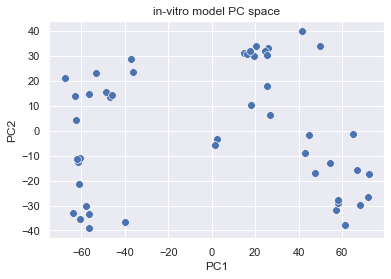

In [8]:
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# pca_data = pd.concat([pca_data,pd.DataFrame(data={'PC1':Z_A_B[:,0], 'PC2':Z_A_B[:,1]})])
# pca_data['dataset'] = ['in-vitro model' for i in range(Z_B.shape[0])] + ['humans' for i in range(Z_A_B.shape[0])]
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2', s =60 , palette= 'icefire')
plt.title('in-vitro model PC space')

In [9]:
loadings = pca.components_
print(loadings.shape)

(48, 26001)


In [10]:
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

The explained variance of the human data in the PC-space of liver chip is 32.44 %


In [11]:
# varA_filt = np.var(np.dot(np.dot(X_A,Wh),Wh.T),axis=0).sum()
# Z_A_B_filt = np.dot(np.dot(np.dot(X_A,Wh),Wh.T),loadings.T)
# varAB_filt = np.var(Z_A_B_filt,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB_filt/varA_filt))

In [12]:
# varA_filt = np.var(X_A-np.dot(np.dot(X_A,Wh),Wh.T),axis=0).sum()
# Z_A_B_filt = np.dot(X_A-np.dot(np.dot(X_A,Wh),Wh.T),loadings.T)
# varAB_filt = np.var(Z_A_B_filt,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB_filt/varA_filt))

# Initialize perturbation as a small random dX

In [13]:
XB_lean = X_B.loc[lean_control_ind,:].values.reshape(1,X_B.shape[1])
XB_fatty = X_B.loc[fatty_control_ind,:].values.reshape(1,X_B.shape[1])
dim_init = XB_lean.shape[1]
dX_lean = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,dim_init))
dX_lean = torch.tensor(dX_lean).float().to(device)
# dX_fatty = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,XB_fatty.shape[1]))
# dX_fatty = torch.tensor(dX_fatty).float().to(device)
# Input_fatty = torch.nn.Parameter(dX_fatty, requires_grad = True)
# Input_fatty.retain_grad()
Input_lean = torch.nn.Parameter(dX_lean, requires_grad = True)
Input_lean.retain_grad()
# optimizer = torch.optim.Adam([Input_lean,Input_fatty],lr= 0.1,weight_decay=0)
optimizer = torch.optim.Adam([Input_lean],lr= 0.1,weight_decay=0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                             step_size=150,
#                                             gamma=0.8)
XB_lean = torch.tensor(XB_lean).float().to(device)
XB_lean = torch.mean(XB_lean,0,keepdim = True)
# XB_fatty = torch.tensor(XB_fatty).float().to(device)
# XB_fatty = torch.mean(XB_fatty,0,keepdim = True)
XB = torch.tensor(X_B.values).float().to(device)
XA = torch.tensor(X_A.values).float().to(device)
W_A = torch.tensor(Wh.values).float().to(device)
W_B_extra = torch.tensor(W_extra.values).float().to(device)

In [14]:
# print(XB_fatty.shape)
print(XB_lean.shape)

torch.Size([1, 26001])


Sample 0 Iteration=0, loss=-0.3210, explained_variance=32.62%
Sample 0 Iteration=200, loss=-0.4311, explained_variance=43.23%
Sample 0 Iteration=400, loss=-0.4301, explained_variance=43.41%
Sample 0 Iteration=600, loss=-0.4328, explained_variance=43.42%
Sample 0 Iteration=800, loss=-0.4286, explained_variance=43.35%
Sample 0 Iteration=999, loss=-0.4292, explained_variance=43.40%
Sample 1 Iteration=0, loss=-0.3211, explained_variance=32.62%
Sample 1 Iteration=200, loss=-0.4323, explained_variance=43.35%
Sample 1 Iteration=400, loss=-0.4329, explained_variance=43.38%
Sample 1 Iteration=600, loss=-0.4299, explained_variance=43.41%
Sample 1 Iteration=800, loss=-0.4312, explained_variance=43.42%
Sample 1 Iteration=999, loss=-0.4325, explained_variance=43.42%
Sample 2 Iteration=0, loss=-0.3211, explained_variance=32.63%
Sample 2 Iteration=200, loss=-0.4323, explained_variance=43.37%
Sample 2 Iteration=400, loss=-0.4325, explained_variance=43.42%
Sample 2 Iteration=600, loss=-0.4302, explaine

Sample 21 Iteration=400, loss=-0.4316, explained_variance=43.42%
Sample 21 Iteration=600, loss=-0.4295, explained_variance=43.37%
Sample 21 Iteration=800, loss=-0.4309, explained_variance=43.41%
Sample 21 Iteration=999, loss=-0.4328, explained_variance=43.43%
Sample 22 Iteration=0, loss=-0.3210, explained_variance=32.62%
Sample 22 Iteration=200, loss=-0.4302, explained_variance=43.13%
Sample 22 Iteration=400, loss=-0.4308, explained_variance=43.41%
Sample 22 Iteration=600, loss=-0.4185, explained_variance=41.96%
Sample 22 Iteration=800, loss=-0.4320, explained_variance=43.42%
Sample 22 Iteration=999, loss=-0.4330, explained_variance=43.42%
Sample 23 Iteration=0, loss=-0.3209, explained_variance=32.62%
Sample 23 Iteration=200, loss=-0.4305, explained_variance=43.16%
Sample 23 Iteration=400, loss=-0.4296, explained_variance=43.41%
Sample 23 Iteration=600, loss=-0.4329, explained_variance=43.38%
Sample 23 Iteration=800, loss=-0.4291, explained_variance=43.40%
Sample 23 Iteration=999, loss

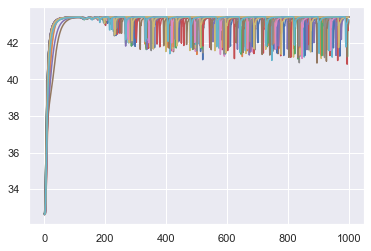

In [15]:
df_lean = pd.DataFrame({})
# df_fatty = pd.DataFrame({})
iters = 1000
# torch.autograd.set_detect_anomaly(True)
# j=0
all_dx = np.zeros((30,XB.shape[1]))
for j in range(30):
    dX_lean = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,dim_init))
    dX_lean = torch.tensor(dX_lean).float().to(device)
    Input_lean = torch.nn.Parameter(dX_lean, requires_grad = True)
    Input_lean.retain_grad()
    optimizer = torch.optim.Adam([Input_lean],lr= 0.1,weight_decay=0)
    torch.autograd.set_detect_anomaly(True)
    loss_all = []
    exp_var_all = []
    for i in range(iters):
        optimizer.zero_grad()
        Xstar_lean = XB_lean + Input_lean
        #Xstar_fatty = XB_fatty + Input_fatty
        #X = torch.concat((XB,Xstar_lean,Xstar_fatty),0)
        X = torch.concat((XB,Xstar_lean),0)
        U,S,V = torch.svd(X)
        #Z_A_B = torch.matmul(XA,P.T)
        Z_A_B = torch.matmul(XA,V)
        varAB = torch.var(Z_A_B,axis=0).sum()

        ## spearman loss
        #lean_spear = torch.abs(spearman_corr(Input_lean.squeeze(),W_B_extra[:,0]))
        #lean_spear = lean_spear + torch.abs(spearman_corr(Input_lean.squeeze(),W_B_extra[:,1]))
        #fatty_spear = spearman_corr(Input_fatty.squeeze(),W_B_extra[:,0]) + spearman_corr(Input_fatty.squeeze(),W_B_extra[:,1])

        loss = - varAB/varA
        loss = loss + 1e-6 * torch.sum(torch.abs(Input_lean))

        loss.backward()
        optimizer.step()
        #scheduler.step()

        exp_var = 100 * varAB/varA
        exp_var = exp_var.item()
        loss_all.append(loss.item())
        exp_var_all.append(exp_var)
        if i % 200 == 0 :
            outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', explained_variance={:.2f}%'.format(exp_var)
            print(outString)
    outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
    outString += ', loss={:.4f}'.format(loss.item())
    outString += ', explained_variance={:.2f}%'.format(exp_var)
    print(outString)
    plt.plot(range(iters),exp_var_all)
    all_dx[j,:] = Input_lean.detach().cpu().numpy()
    j = j +1
# lean_dx = pd.DataFrame(Input_lean.detach().cpu().numpy())
lean_dx = pd.DataFrame(np.mean(all_dx,0)).T
lean_dx.columns = X_B.columns.values
lean_dx_std = pd.DataFrame(np.std(all_dx,0)).T
lean_dx_std.columns = X_B.columns.values
df_lean = df_lean.append(lean_dx)
# fatty_dx = pd.DataFrame(Input_fatty.detach().cpu().numpy())
# fatty_dx.columns = X_B.columns.values
# df_fatty = df_fatty.append(fatty_dx)

In [16]:
# df_fatty.index = [i for i in range(XB_fatty.shape[0])]
df_lean.index = [i for i in range(XB_lean.shape[0])]

In [17]:
df_lean

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,DDX51,YBX2,NANOS3,ISLR,CHEK2P5,TMEM95,C1R,OR4F4,PRKACA,GOLGA6L2
0,0.032338,-0.000016,0.012758,-0.019441,-0.008329,-0.120255,-0.018411,0.027102,0.040989,-0.035627,...,-0.078323,-0.100087,0.004078,-0.083133,0.0,-0.001559,-0.067942,0.001059,-0.035371,-0.000201


(array([2.0000e+00, 2.0000e+00, 9.0000e+00, 3.0000e+01, 2.8300e+02,
        4.7690e+03, 1.9864e+04, 9.9300e+02, 4.4000e+01, 5.0000e+00]),
 array([-0.57107966, -0.47912557, -0.38717149, -0.29521741, -0.20326332,
        -0.11130924, -0.01935516,  0.07259892,  0.16455301,  0.25650709,
         0.34846117]),
 <BarContainer object of 10 artists>)

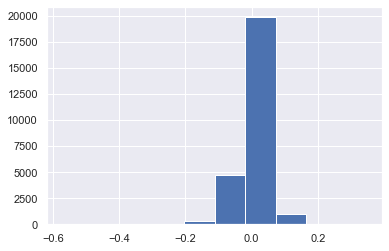

In [18]:
plt.hist(lean_dx.values.squeeze())

(array([2.1468e+04, 3.5560e+03, 7.6100e+02, 1.5200e+02, 4.0000e+01,
        1.3000e+01, 7.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([0.        , 0.22782396, 0.45564791, 0.68347187, 0.91129583,
        1.13911978, 1.36694374, 1.59476769, 1.82259165, 2.05041561,
        2.27823956]),
 <BarContainer object of 10 artists>)

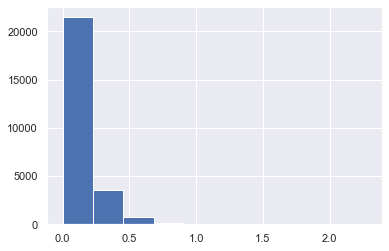

In [19]:
plt.hist(lean_dx_std.values.squeeze())

In [48]:
# df_fatty

In [21]:
df_lean.to_csv('../results/optimized_mps/dx_lean_govaere_kostrzewski_corrected.csv')
# df_fatty.to_csv('../results/optimized_mps/dx_fatty_govaere_kostrzewski.csv')

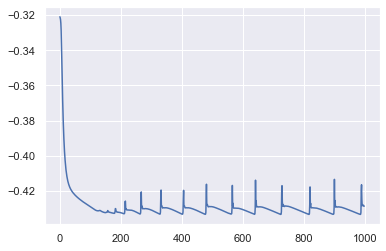

In [20]:
plt.plot(range(iters),loss_all)

In [51]:
# plt.plot(range(iters),exp_var_all)

(array([2.20304126e-04, 2.75380064e-03, 8.37155394e-03, 2.96308999e-02,
        1.16981471e-01, 3.55130191e-01, 1.68763933e+00, 4.34219359e-01,
        1.48595095e-01, 4.91278118e-02, 1.79547802e-02, 7.15988411e-03,
        3.74516887e-03, 1.65228095e-03, 4.40607952e-04, 2.20304126e-04,
        0.00000000e+00, 1.10152063e-04, 0.00000000e+00, 1.10151988e-04]),
 array([-2.3833632 , -2.034209  , -1.6850547 , -1.3359003 , -0.986746  ,
        -0.6375917 , -0.28843743,  0.06071689,  0.4098712 ,  0.7590255 ,
         1.1081798 ,  1.4573342 ,  1.8064884 ,  2.1556427 ,  2.504797  ,
         2.8539515 ,  3.2031057 ,  3.55226   ,  3.9014142 ,  4.2505684 ,
         4.599723  ], dtype=float32),
 <BarContainer object of 20 artists>)

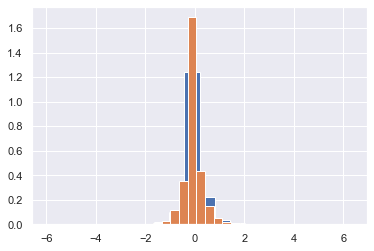

In [22]:
plt.hist(XB.detach().cpu().numpy().flatten(),20,density=True)
# plt.hist(Xstar_fatty.detach().cpu().numpy().flatten(),20,density=True)
plt.hist(Xstar_lean.detach().cpu().numpy().flatten(),20,density=True)

(array([8.36505741e-04, 8.36505741e-04, 0.00000000e+00, 1.67301148e-03,
        2.50951722e-03, 5.01903445e-03, 8.36505741e-03, 1.67301148e-02,
        4.18252870e-02, 1.94905838e-01, 8.34832729e-01, 3.15446315e+00,
        1.38742842e+01, 2.74206582e+00, 7.08520363e-01, 1.22129838e-01,
        2.67681837e-02, 1.00380689e-02, 1.67301148e-03, 2.50951722e-03]),
 array([-0.57107966, -0.52510262, -0.47912557, -0.43314853, -0.38717149,
        -0.34119445, -0.29521741, -0.24924037, -0.20326332, -0.15728628,
        -0.11130924, -0.0653322 , -0.01935516,  0.02662188,  0.07259892,
         0.11857597,  0.16455301,  0.21053005,  0.25650709,  0.30248413,
         0.34846117]),
 <BarContainer object of 20 artists>)

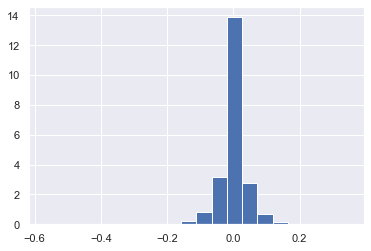

In [23]:
plt.hist(df_lean.values.flatten(),20,density=True)

In [54]:
# plt.hist(df_fatty.values.flatten(),20,density=True)

### Validate with sklearn

In [24]:
# Xstar_lean = XB_lean + Input_lean
Xstar_lean = XB_lean + torch.tensor(lean_dx.values).to(device)
# Xstar_fatty = XB_fatty + Input_fatty
# X = torch.concat((XB,Xstar_lean,Xstar_fatty),0)
X = torch.concat((XB,Xstar_lean),0)
X = X.detach().cpu().numpy()

In [25]:
lean_ind = np.where(np.isin(X_B.index.values, lean_control_ind))[0]
# fatty_ind = np.where(np.isin(X_B.index.values, fatty_control_ind))[0]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

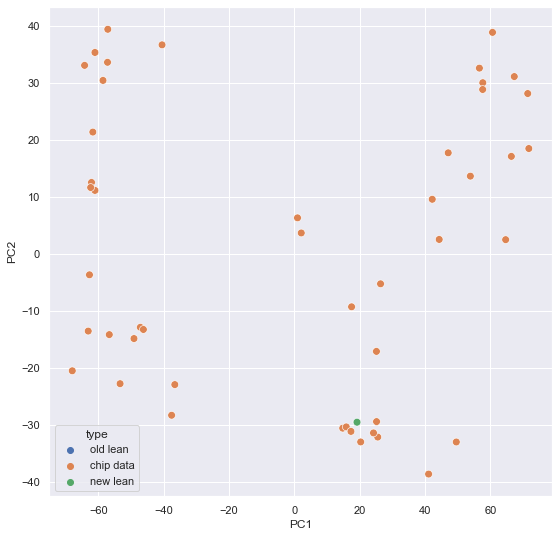

In [26]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X)
# transform your data into PCA space
Z_B = pca.transform(X)
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
# pca_data["type"] = ['chip data' for i in range(XB.shape[0])] + ['new lean' for i in range(XB_lean.shape[0])] + ['new fatty' for i in range(XB_fatty.shape[0])]
pca_data["type"] = ['chip data' for i in range(XB.shape[0])] + ['new lean' for i in range(XB_lean.shape[0])] 
pca_data.iloc[lean_ind,2] = 'old lean'
# pca_data.iloc[fatty_ind,2] = 'old fatty'
plt.figure(figsize=(9, 9))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 ,hue='type')

In [27]:
loadings = pca.components_
print(loadings.shape)
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

(49, 26001)
The explained variance of the human data in the PC-space of liver chip is 43.18 %


In [28]:
# varA_filt = np.var(np.dot(np.dot(X_A,Wh),Wh.T),axis=0).sum()
# Z_A_B_filt = np.dot(np.dot(np.dot(X_A,Wh),Wh.T),loadings.T)
# varAB_filt = np.var(Z_A_B_filt,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB_filt/varA_filt))

In [29]:
# varA_filt = np.var(X_A-np.dot(np.dot(X_A,Wh),Wh.T),axis=0).sum()
# Z_A_B_filt = np.dot(X_A-np.dot(np.dot(X_A,Wh),Wh.T),loadings.T)
# varAB_filt = np.var(Z_A_B_filt,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB_filt/varA_filt))

### Perturb with dX all lean and fatty samples

In [30]:
XB_lean = X_B.loc[lean_control_ind,:]
# XB_fatty = X_B.loc[fatty_control_ind,:]
XB_lean = torch.tensor(XB_lean.values).float().to(device)
# XB_fatty = torch.tensor(XB_fatty.values).float().to(device)

In [31]:
Xstar_lean = XB_lean + torch.tensor(df_lean.values).to(device)
# Xstar_fatty = XB_fatty + torch.tensor(df_fatty.values).to(device)

In [32]:
df_lean = np.concatenate([XB_lean.detach().cpu().numpy().reshape(1,X_B.shape[1]),
                          Xstar_lean.detach().cpu().numpy()],0)
df_lean = pd.DataFrame(df_lean)
df_lean.columns = X_B.columns.values
df_lean.index = ['control'+str(i) for i in range(Xstar_lean.shape[0])] + ['perturbed'+str(i) for i in range(Xstar_lean.shape[0])]
df_lean = df_lean.T
df_lean.to_csv('../results/optimized_mps/pertubed_control_lean_corrected.csv')

In [69]:
# df_fatty = np.concatenate([XB_fatty.detach().cpu().numpy().reshape(1,X_B.shape[1]),
#                            Xstar_fatty.detach().cpu().numpy()],0)
# df_fatty = pd.DataFrame(df_fatty)
# df_fatty.columns = X_B.columns.values
# df_fatty.index = ['control'+str(i) for i in range(Xstar_fatty.shape[0])] + ['perturbed'+str(i) for i in range(Xstar_fatty.shape[0])]
# df_fatty = df_fatty.T
# df_fatty.to_csv('../results/optimized_mps/pertubed_control_fatty.csv')

In [33]:
# X = torch.concat((XB,Xstar_lean,Xstar_fatty),0)
X = torch.concat((XB,Xstar_lean),0)
X = X.detach().cpu().numpy()

In [34]:
lean_ind = np.where(np.isin(X_B.index.values, lean_control_ind))[0]
# fatty_ind = np.where(np.isin(X_B.index.values, fatty_control_ind))[0]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

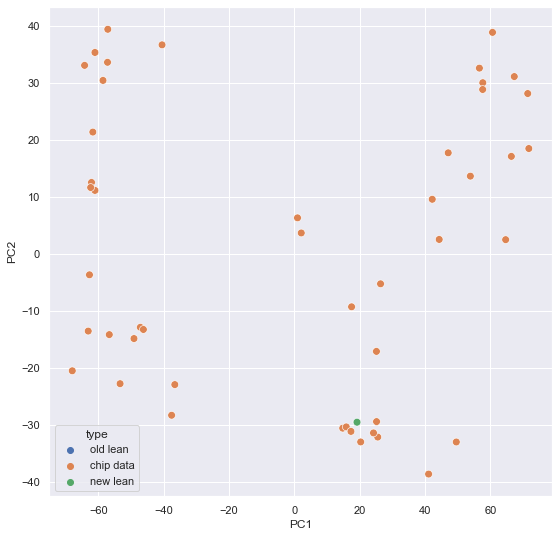

In [35]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X)
# transform your data into PCA space
Z_B = pca.transform(X)
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
pca_data["type"] = ['chip data' for i in range(XB.shape[0])] + ['new lean' for i in range(Xstar_lean.shape[0])] #+ ['new fatty' for i in range(Xstar_fatty.shape[0])]
pca_data.iloc[lean_ind,2] = 'old lean'
# pca_data.iloc[fatty_ind,2] = 'old fatty'
plt.figure(figsize=(9, 9))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 ,hue='type')

In [36]:
loadings = pca.components_
print(loadings.shape)
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

(49, 26001)
The explained variance of the human data in the PC-space of liver chip is 43.18 %


In [37]:
# varA_filt = np.var(np.dot(np.dot(X_A,Wh),Wh.T),axis=0).sum()
# Z_A_B_filt = np.dot(np.dot(np.dot(X_A,Wh),Wh.T),loadings.T)
# varAB_filt = np.var(Z_A_B_filt,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB_filt/varA_filt))

In [38]:
# varA_filt = np.var(X_A-np.dot(np.dot(X_A,Wh),Wh.T),axis=0).sum()
# Z_A_B_filt = np.dot(X_A-np.dot(np.dot(X_A,Wh),Wh.T),loadings.T)
# varAB_filt = np.var(Z_A_B_filt,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB_filt/varA_filt))